In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from scipy.interpolate import NearestNDInterpolator

# Creating HWRF Plots
---
## 1. Get Paths 
- 1.1 Define relevant paths
- 1.2 Define getTime() for future convenience
- 1.3 Define a .tpc file reader to find lat,lon of center of given storm at given hour

#### 1.1 Define relevant paths

In [ ]:
#get paths; for nc paths, omit the last .f___.nc
ncPath1 = '/data2/qy2216/HWRF_wind/hwrf.2021072718/nepartak11w/nc/nepartak11w.2021072718'
tpcPath1 = '/data2/qy2216/HWRF_wind/hwrf.2021072718/nepartak11w/track/NEPARTAK11W.2021072718.stats.tpc'

ncPath2 = '/data2/qy2216/HWRF_wind/hwrf.2021102118/invest92e/nc/invest92e.2021102118'
tpcPath2 = '/data2/qy2216/HWRF_wind/hwrf.2021102118/invest92e/track/INVEST92E.2021102118.stats.tpc'

#### 1.2 Define getTime() for future convenience

In [2]:
def getTime(ncPath):
    return ncPath[-10:]

time1 = getTime(ncPath1)
time2 = getTime(ncPath2)

#define start and end hours of data
startHour = 0
endHour = 33
stepHour = 3

#### 1.3 Define a .tpc file reader to find lat,lon of center of given storm at given hour

In [3]:
#read .tpc files
colspecs = [(5, 10), (18, 25), (32, 38), (56, 63), (89, 95)]

def readTPC(tpc):
    colspecs = [(5, 10), (18, 25), (32, 38), (56, 63), (89, 95)]
    df = pd.read_fwf(tpc, colspecs=colspecs, header=None, skiprows=12, names=['hour', 'lon', 'lat', 'P', 'V'])
    df = df[:41]
    df['hour'] = df['hour'].astype(float)
    df['lat'] = df['lat'].astype(float)
    df['lon'] = df['lon'].astype(float)
    return df

---
## 2. Create Polar Plots for each Hour of Storm 
- 2.1 Create Polar Grid
- 2.2 Define function to interpolate
    - Center the data with data from .tpc file (1)
    - Use NearestNDInterpolator to interpolate onto Polar Grid
- 2.3 Loop Over Datasets to Prepare and Plot Data

#### 2.1 Create Polar Grid

In [4]:
#create polar grid
ntheta_pts = 201
nr_pts = 200
rmax = 300

#FIX rmax name
r1 = np.linspace(0, rmax, nr_pts)
theta1 = np.linspace(-np.pi, np.pi, ntheta_pts)

theta2, r2 = np.meshgrid(theta1, r1)

# cartesian coordinates (in km) of the polar coordinates
polar_x2 = r2 * np.cos(theta2)
polar_y2 = r2 * np.sin(theta2)

#### 2.2 Define function to interpolate

In [5]:
#Create Interpolate Function

def makeInterp(dsi, i, tpcPath, gridx = polar_x2, gridy = polar_y2):
    zi = dsi.APCP_surface.isel(time=0).values
    loni = dsi.longitude.values
    lati = dsi.latitude.values
    df = readTPC(tpcPath)
    xcenteri = df[df.hour == i].lon.values[0]
    ycenteri = df[df.hour == i].lat.values[0]
    xi1 = (loni - xcenteri)*np.cos(np.deg2rad(ycenteri))*110.567
    yi1 = (lati - ycenteri)*110.567
    xi2,yi2 = np.meshgrid(xi1,yi1)
    # number of points X 2 matrix of x y
    xyi = np.stack((xi2.flatten(), yi2.flatten())).T

    interpi = NearestNDInterpolator(xyi, zi.flatten())
    Zi = interpi(gridx, gridy)
    return Zi

#### 2.3 Loop Over Datasets to Prepare and Plot Data

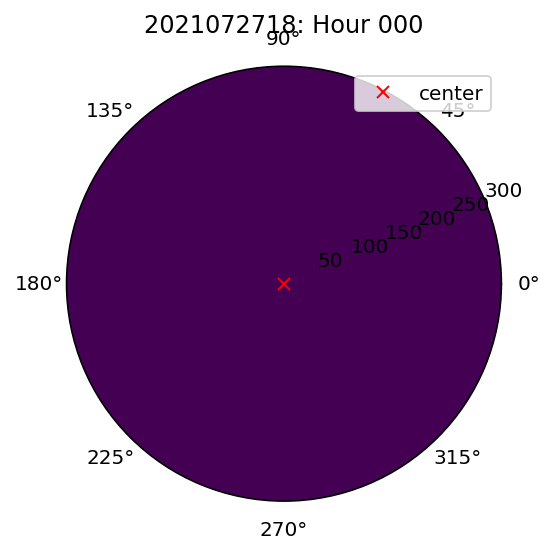

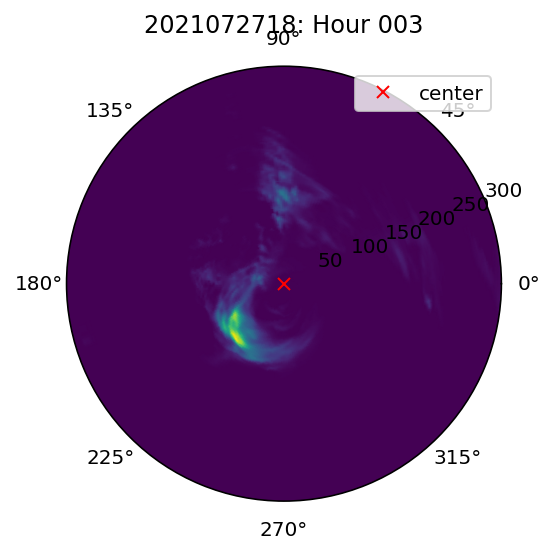

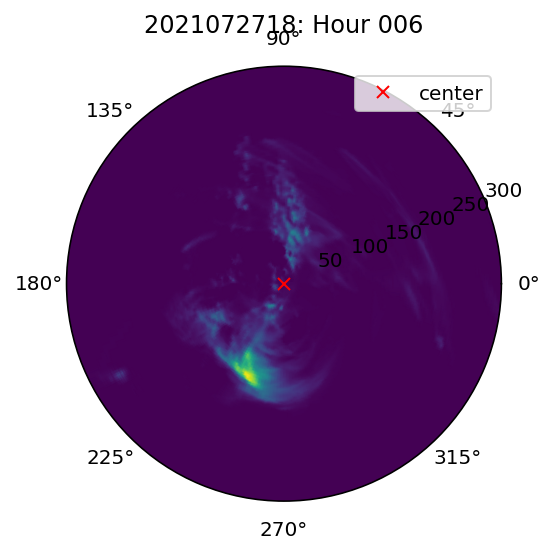

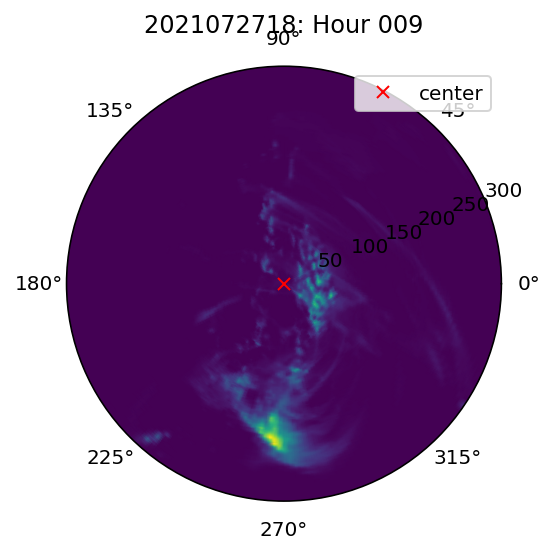

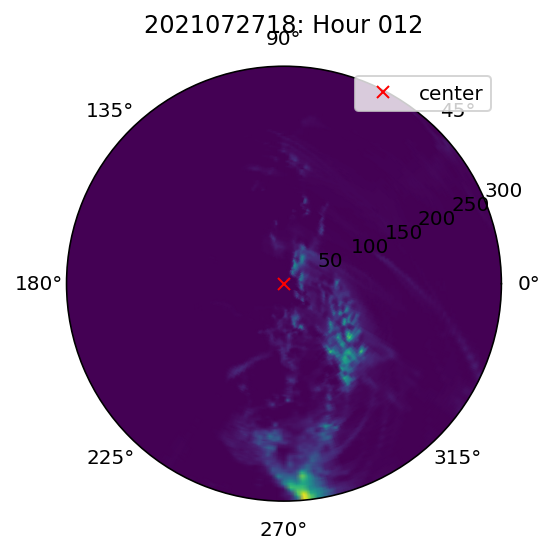

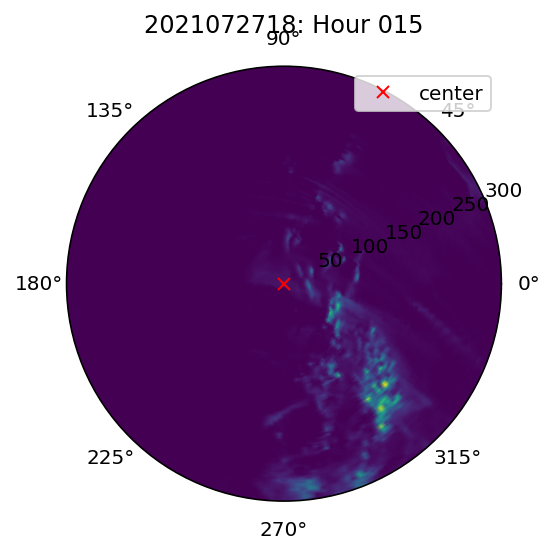

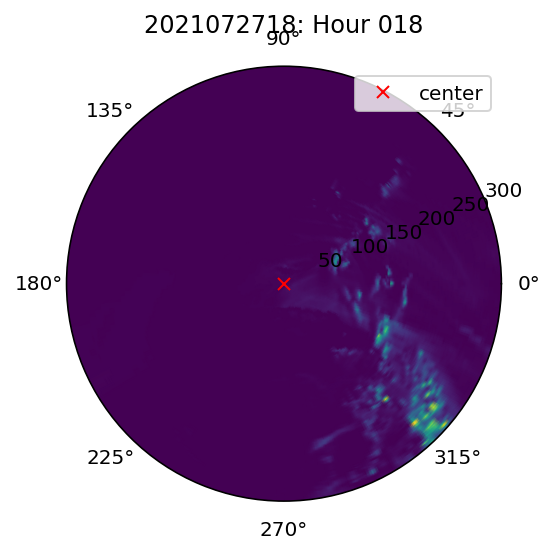

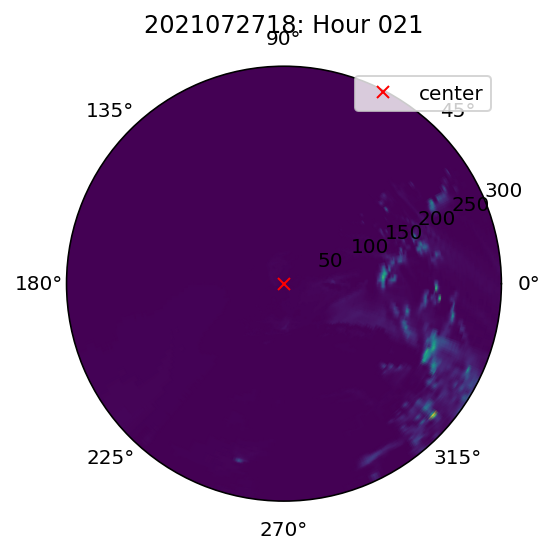

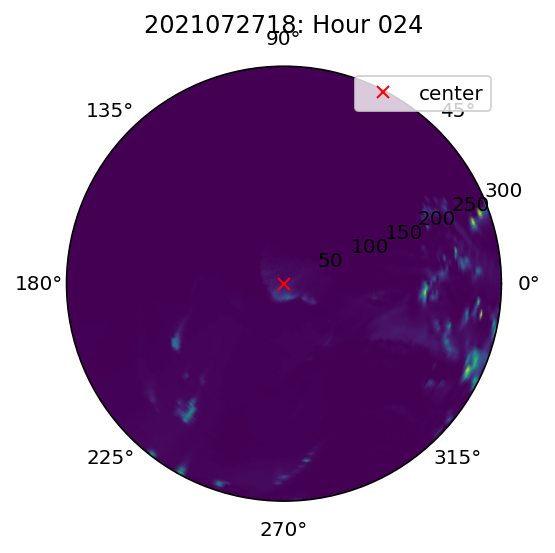

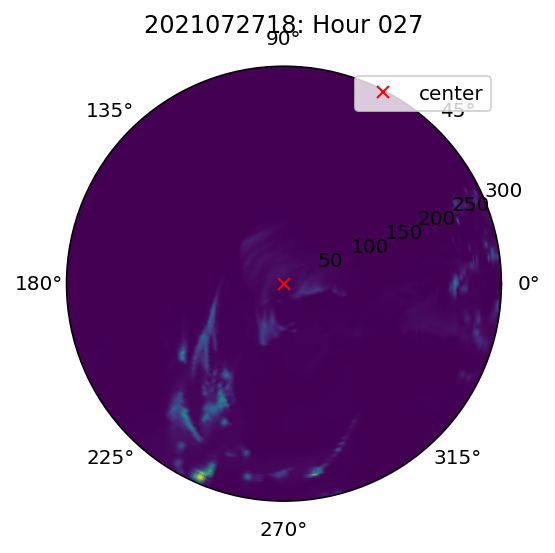

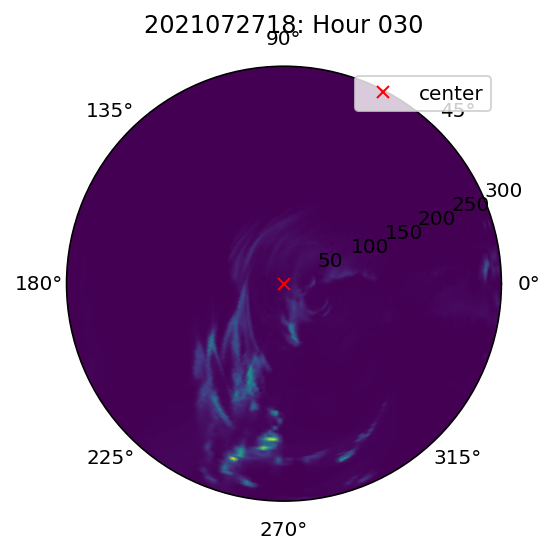

In [6]:
#Loop and plot multiple hours of the storm

def plotMultiple(t,ncPath,tpcPath):
    for i,j in enumerate(range(startHour,endHour,stepHour)):
        #print('%03d' % i)
        hour = '%03d' % j
        ds = xr.open_dataset(ncPath+'.f'+hour+'.nc')
        Z = makeInterp(ds, j, tpcPath)

        plt.figure()
        plt.subplot(projection="polar")
        plt.pcolormesh(theta1, r1, Z, shading='gouraud')
        plt.plot(0, 0, 'rx', label='center')
        plt.title(str(t) + ": Hour " + hour)
        plt.legend()
    
    plt.gca().set_aspect('equal')
    plt.show()
    
plotMultiple(time1,ncPath1,tpcPath1)

---
## 3. Superimposed Plot of Centered Data
- 3.1 Define function to calculate cumulative centered data
    - Make array containing the datasets from startHour to endHour
    - Use np.sum() to find total rainfall
- 3.2 Create plot for cumulative (superimposed) centered data
- 3.3 Create plot for mean rainfall rates (figure 11 of 2004 Lonfat et al.)

#### 3.1 Define function to calculate cumulative centered data

In [7]:
#make array containing the datasets from startHour to endHour
numData = (endHour-startHour)//stepHour

def findTotalCentered(t,ncPath,tpcPath):
    dataarray = np.zeros(numData, dtype=np.ndarray)
    for i,j in enumerate(range(startHour,endHour,3)):
        hour = '%03d' % j  
        ds = xr.open_dataset(ncPath+'.f'+ hour+'.nc')
        dataarray[i] = makeInterp(ds, j, tpcPath, polar_x2, polar_y2) 

    #find total rainfall
    centeredCum = np.sum(dataarray, axis=0)
    return dataarray, centeredCum

#### 3.2 Create plot for cumulative (superimposed) centered data

In [ ]:
def plotTotalCentered(t,centeredCum):
    #Plot total rainfall
    plt.figure()
    plt.subplot(projection="polar")
    plt.pcolormesh(theta1, r1, centeredCum, shading='gouraud')
    plt.plot(0, 0, 'rx', label='center')
    plt.title("Superimposed Centered Data: " + str(t))
    plt.legend()

    plt.gca().set_aspect('equal')
    plt.show()

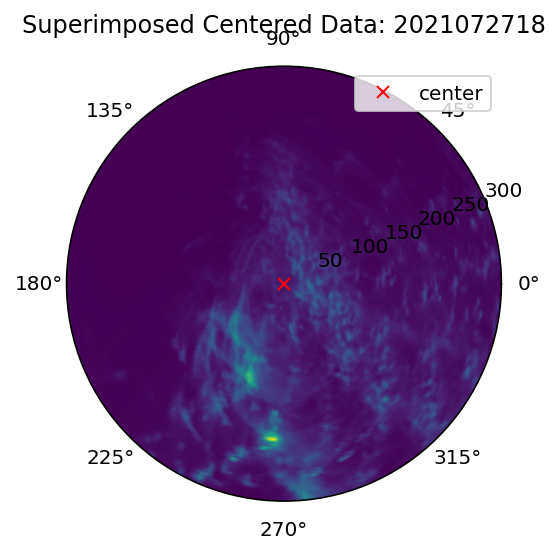

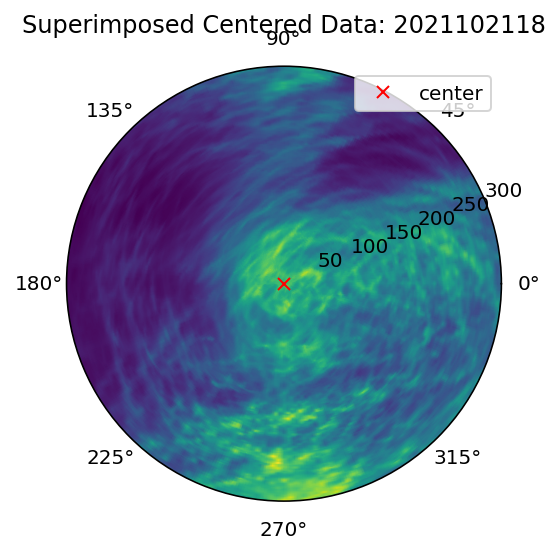

In [8]:
centeredCum1 = findTotalCentered(time1,ncPath1,tpcPath1)[1]
plotTotalCentered(time1,centeredCum1)

centeredCum2 = findTotalCentered(time2,ncPath2,tpcPath2)[1]
plotTotalCentered(time2,centeredCum2)

#### 3.3 Create plot for mean rainfall rates (figure 11 of 2004 Lonfat et al.)

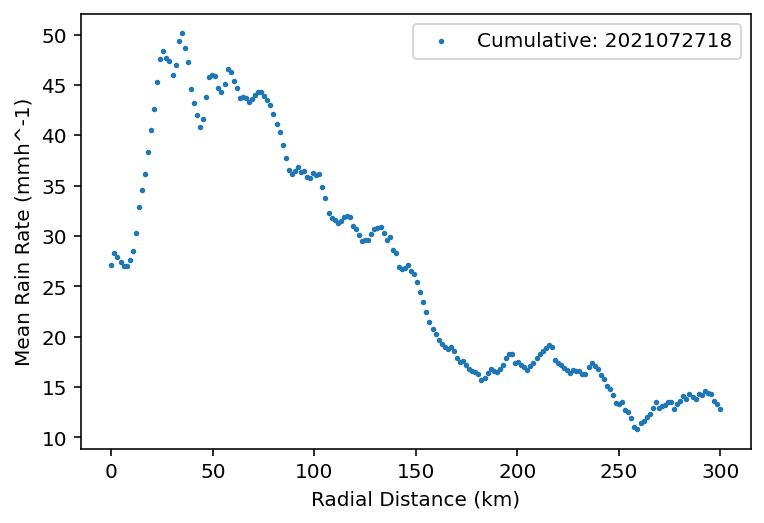

In [9]:
def plotMeanRainfallRate(t,ds):
    meanRainfall = np.mean(ds, axis=1)
    
    plt.scatter(r1,meanRainfall,s=3, label = "Cumulative: " + str(t))
    plt.xlabel("Radial Distance (km)")
    plt.ylabel("Mean Rain Rate (mmh^-1)")
    plt.legend()
    plt.show()
    
plotMeanRainfallRate(time1,centeredCum1)

---
## 4. Superimposed Plot of Moving Center Data
- 4.1 Define function to find corners (extrema) of given datasets of a storm
- 4.2 Create cartesian grid with the corners found in 4.1
- 4.3 Define function to calculate cumulative moving center data
    - Make array containing the datasets from startHour to endHour after being interpolated onto the cartesian grid from 4.2
    - Use np.sum() to find total rainfall
- 4.4 Create plot for cumulative (superimposed) moving center data

#### 4.1 Define function to find corners (extrema) of given datasets of a storm

In [10]:
#find corners
def findCorners(t,ncPath):
    minx = np.inf
    maxx = -np.inf
    miny = np.inf
    maxy = -np.inf
    for i,j in enumerate(range(startHour,endHour,stepHour)):
        hour = '%03d' % j  
        ds = xr.open_dataset(ncPath+'.f'+ hour+'.nc')
        if min(ds.longitude.values)<minx:
            minx = min(ds.longitude.values)
        if max(ds.longitude.values)>maxx:
            maxx = max(ds.longitude.values)
        if min(ds.latitude.values)<miny:
            miny = min(ds.latitude.values)
        if max(ds.latitude.values)>maxy:
            maxy = max(ds.latitude.values)
    return minx,maxx,miny,maxy

print(findCorners(time1,ncPath1))

(131.5, 145.49999999999181, 33.413, 46.15)


#### 4.2 Create cartesian grid with the corners found in 4.1

In [14]:
#create cartesian grid
nx_pts = 100
ny_pts = 100
corners = findCorners(time1,ncPath1)

x1 = np.linspace(corners[0], corners[1], nx_pts)
y1 = np.linspace(corners[2], corners[3], ny_pts)

x2, y2 = np.meshgrid(x1, y1)

#### 4.3 Define function to calculate cumulative moving center data

In [15]:
def findTotalMovingCenter(t,ncPath,tpcPath):
    dataarray = np.zeros(numData, dtype=np.ndarray)
    for i,j in enumerate(range(startHour,endHour,stepHour)):
        hour = '%03d' % j  
        ds = xr.open_dataset(ncPath+'.f'+ hour+'.nc')
        dataarray[i] = makeInterp(ds, j, tpcPath, x2, y2)

    #find total rainfall
    cum = np.sum(dataarray, axis=0)
    return dataarray, cum

#### 4.4 Create plot for cumulative (superimposed) moving center data

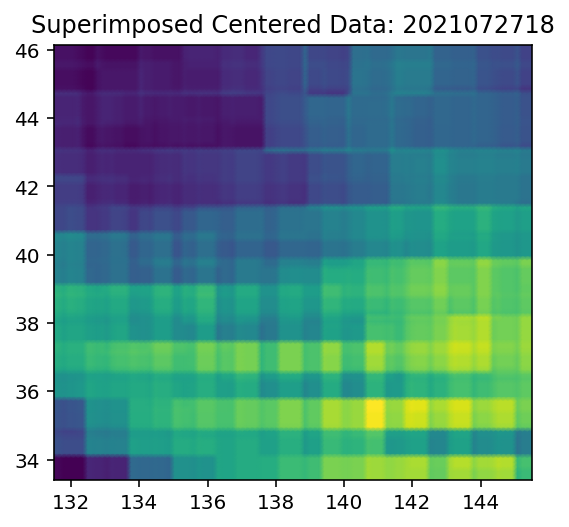

In [16]:
def plotTotalMovingCenter(t,cum):
    #Plot total rainfall
    plt.figure()
    plt.pcolormesh(x1, y1, cum, shading='gouraud')
    plt.title("Superimposed Centered Data: " + str(t))

    plt.gca().set_aspect('equal')
    plt.show()

cum1 = findTotalMovingCenter(time1,ncPath1,tpcPath1)[1]
plotTotalMovingCenter(time1,cum1)